In [1]:
# for mac
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(244,244,3))
vgg.summary()

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_____________________________________________

In [3]:
import glob
import pandas as pd
# 先不讀取圖片 catdog_train
df = pd.DataFrame(columns=["path", "target"])
for p in glob.glob("catdog_train/train/cat.*.jpg"):
    s = pd.Series([p, 0], index=["path", "target"])
    df = df.append(s, ignore_index=True)
for p in glob.glob("catdog_train/train/dog.*.jpg"):
    s = pd.Series([p, 1], index=["path", "target"])
    df = df.append(s, ignore_index=True)
df

,path,target
0,catdog_train/train\cat.0.jpg,0
1,catdog_train/train\cat.1.jpg,0
2,catdog_train/train\cat.10.jpg,0
3,catdog_train/train\cat.100.jpg,0
4,catdog_train/train\cat.1000.jpg,0
...,...,...
24995,catdog_train/train\dog.9995.jpg,1
24996,catdog_train/train\dog.9996.jpg,1
24997,catdog_train/train\dog.9997.jpg,1
24998,catdog_train/train\dog.9998.jpg,1


catdog_train/train\dog.4053.jpg
(244, 244)


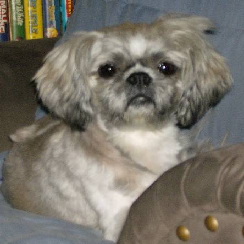

In [11]:
from keras.preprocessing.image import load_img
import random
c = random.randint(0, 24999)
print(df["path"][c])
img = load_img(df["path"][c])
print(img.size)
img

(224, 224)


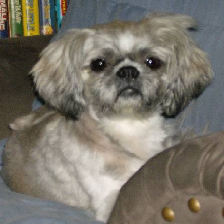

In [12]:
img = load_img(df["path"][c], target_size=(224, 224))
print(img.size)
img

In [40]:
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization
# 把 CNN 的部分固定住
# CNN 眼睛
for l in vgg.layers:
    l.trainable = False
# BN(血管)
x = BatchNormalization()(vgg.output)
# Flatten()=<keras.layers.core.Flatten at 0x1c98869c548> 不為數值 參數 , 為一個功能
# MLP(大腦)
x = Flatten()(x)
# Dense()= <keras.layers.core.Dense at 0x1c9886ba608> 不為數值 參數 , 為一個功能
x = Dense(units=2048, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
# 貓合狗的分類 : units = 1 , units = 2 都可以
#            : sigmoid (轉成 0 - 1) , softmax (兩個相加 = 1)
x = Dense(units=2, activation="softmax")(x)
cnn = Model(inputs=vgg.input, outputs=x)
cnn.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0   

In [41]:
vgg.layers

In [42]:
cnn.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [51]:
# 不要一開始就讀圖
from sklearn.model_selection import train_test_split
# 真的要開始切分訓練與測試資料, 請把 pandas 轉成 numpy 的 array
# 先處理答案, one-hot encoding
from keras.utils.np_utils import to_categorical
y_cat = to_categorical(df["target"])
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(y_cat),
                                                    test_size=0.1)
# show 一個 y_train
y_train[0]

array([1., 0.], dtype=float32)

In [44]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(22500,) (22500, 2)
(2500,) (2500, 2)


In [50]:
# 一次拿很多圖
# 你偷誰的模型, 就要使用他的預處理方式
from keras.applications.vgg16 import preprocess_input
batch_size = 20
for i in range(5):
    # randint(下限(包括), 上限(不包括), 幾個)
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    # numpy好用之處: array[ 索引list ]
    imglist = []
    for fn in x_train[idx]:
        # 讀取圖片並且使用我們偷來的模型的預處理方式來處理一下
        img = load_img(fn, target_size=(224, 224))
        img = preprocess_input(np.array(img))
        imglist.append(img)
    x = np.array(imglist)
    y = y_train[idx]
    result = cnn.train_on_batch(x, y)
    print("-----Times", i, "-----")
    print(result)

ValueError: Error when checking input: expected input_1 to have shape (244, 244, 3) but got array with shape (224, 224, 3)

In [38]:
batch_size = 100
# randint(下限(包括), 上限(不包括), 幾個)
idx = np.random.randint(0, x_test.shape[0], batch_size)
# numpy好用之處: array[ 索引list ]
imglist = []
oriimglist = []
for fn in x_test[idx]:
    # 讀取圖片並且使用我們偷來的模型的預處理方式來處理一下
    img = load_img(fn, target_size=(224, 224))
    # 先把原圖留下來
    oriimglist.append(np.array(img))
    img = preprocess_input(np.array(img))
    imglist.append(img)
x = np.array(imglist)
y = y_test[idx]
cnn.evaluate(x, y)

ValueError: Error when checking input: expected input_1 to have shape (244, 244, 3) but got array with shape (224, 224, 3)

In [49]:
pre = cnn.predict(x).argmax(axis=1)
pre

ValueError: Error when checking input: expected input_1 to have shape (244, 244, 3) but got array with shape (224, 224, 3)

In [ ]:
y.argmax(axis=-1)

In [48]:
np.nonzero(pre != y.argmax(axis=-1))

NameError: name 'pre' is not defined

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
idx = np.nonzero(pre != y.argmax(axis=-1))[0]
width = 5
height = int(len(idx) / 5) + 1
plt.figure(figsize=(14, 6))
for (i, img) in enumerate(np.array(oriimglist)[idx]):
    plt.subplot(height, width, i + 1)
    t = "[P]:" + str(pre[idx][i]) + "[O]:" + str(y.argmax(axis=-1)[idx][i])
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)